<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [ ]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [ ]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [ ]:
nltk.corpus.brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [ ]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [ ]:
len(brown_tagged_sents)

57340

Первое предложение

In [ ]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [ ]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

In [ ]:
len(brown_tagged_words)

1161192

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [ ]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [ ]:
brown_tagged_words

[('the', 'DET'),
 ('fulton', 'NOUN'),
 ('county', 'NOUN'),
 ('grand', 'ADJ'),
 ('jury', 'NOUN'),
 ('said', 'VERB'),
 ('friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.'),
 ('the', 'DET'),
 ('jury', 'NOUN'),
 ('further', 'ADV'),
 ('said', 'VERB'),
 ('in', 'ADP'),
 ('term-end', 'NOUN'),
 ('presentments', 'NOUN'),
 ('that', 'ADP'),
 ('the', 'DET'),
 ('city', 'NOUN'),
 ('executive', 'ADJ'),
 ('committee', 'NOUN'),
 (',', '.'),
 ('which', 'DET'),
 ('had', 'VERB'),
 ('over-all', 'ADJ'),
 ('charge', 'NOUN'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('election', 'NOUN'),
 (',', '.'),
 ('``', '.'),
 ('deserves', 'VERB'),
 ('the', 'DET'),
 ('praise', 'NOUN'),
 ('and', 'CONJ'),
 ('thanks'

In [ ]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

Кол-во предложений:  57340


In [ ]:
words

['the',
 'fulton',
 'county',
 'grand',
 'jury',
 'said',
 'friday',
 'an',
 'investigation',
 'of',
 "atlanta's",
 'recent',
 'primary',
 'election',
 'produced',
 '``',
 'no',
 'evidence',
 "''",
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 '.',
 'the',
 'jury',
 'further',
 'said',
 'in',
 'term-end',
 'presentments',
 'that',
 'the',
 'city',
 'executive',
 'committee',
 ',',
 'which',
 'had',
 'over-all',
 'charge',
 'of',
 'the',
 'election',
 ',',
 '``',
 'deserves',
 'the',
 'praise',
 'and',
 'thanks',
 'of',
 'the',
 'city',
 'of',
 'atlanta',
 "''",
 'for',
 'the',
 'manner',
 'in',
 'which',
 'the',
 'election',
 'was',
 'conducted',
 '.',
 'the',
 'september-october',
 'term',
 'jury',
 'had',
 'been',
 'charged',
 'by',
 'fulton',
 'superior',
 'court',
 'judge',
 'durwood',
 'pye',
 'to',
 'investigate',
 'reports',
 'of',
 'possible',
 '``',
 'irregularities',
 "''",
 'in',
 'the',
 'hard-fought',
 'primary',
 'which',
 'was',
 'won',
 'by',
 'mayor-nominate'

In [ ]:
# Через FreqDist посчитать кол-во words, колво tags и потом получить их значения
from nltk.probability import FreqDist
word_freq, tag_freq = FreqDist(), FreqDist()
for word in words:
  word_freq[word] += 1
for tag in tags:
  tag_freq[tag] += 1

In [ ]:
word_freq

FreqDist({'the': 69971, ',': 58334, '.': 49346, 'of': 36412, 'and': 28853, 'to': 26158, 'a': 23195, 'in': 21337, 'that': 10594, 'is': 10109, ...})

In [ ]:
tag_freq

FreqDist({'NOUN': 275558, 'VERB': 182750, '.': 147565, 'ADP': 144766, 'DET': 137019, 'ADJ': 83721, 'ADV': 56239, 'PRON': 49334, 'CONJ': 38151, 'PRT': 29829, ...})

In [ ]:
pd.Series(tag_freq.values(), tag_freq.keys()).sort_values()

X         1386
NUM      14874
PRT      29829
CONJ     38151
PRON     49334
ADV      56239
ADJ      83721
DET     137019
ADP     144766
.       147565
VERB    182750
NOUN    275558
dtype: int64

In [ ]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(tag_freq.values(), tag_freq.keys()).sort_values(ascending=False) # тег - кол-во тега в корпусе
word_num = pd.Series(word_freq.values(), word_freq.keys()).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [ ]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

In [ ]:
word_num

the            69971
,              58334
.              49346
of             36412
and            28853
               ...  
quasi-folk         1
moneymaking        1
puckish            1
jeepers            1
stupefying         1
Length: 49815, dtype: int64

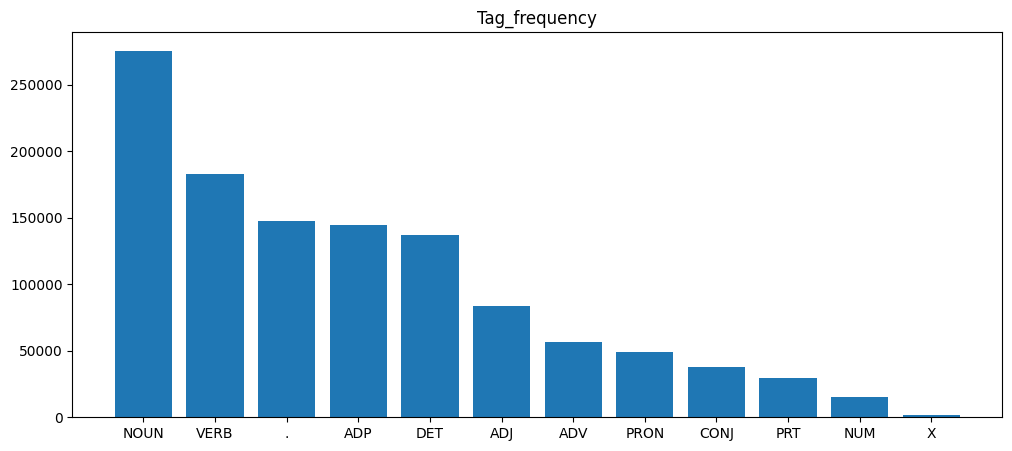

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [ ]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

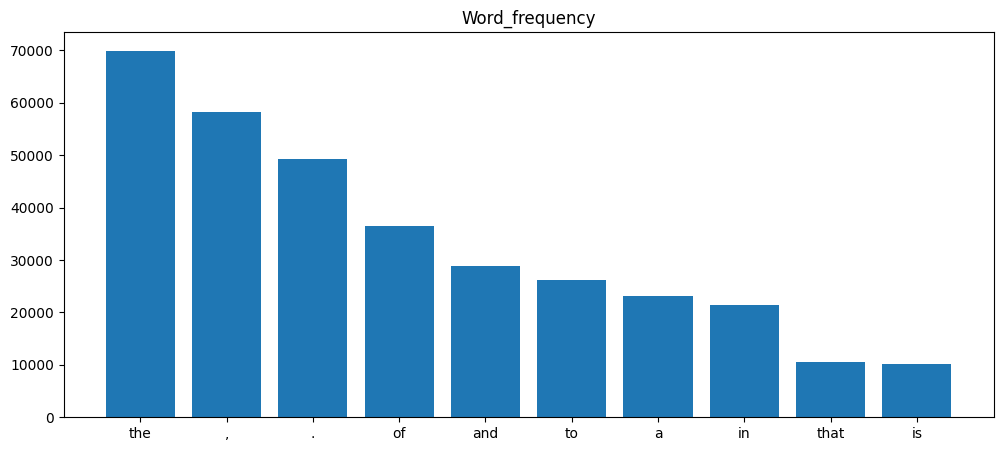

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [ ]:
word_num['cat']

23

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

In [ ]:
word_freq.max() # Самое популярное слово вообще

'the'

In [ ]:
noun_word = []
for (word, tag) in brown_tagged_words:
  if tag == 'NOUN':
    noun_word.append(word)

In [ ]:
words_noun_num = pd.Series(FreqDist(noun_word)).sort_values(ascending=False)

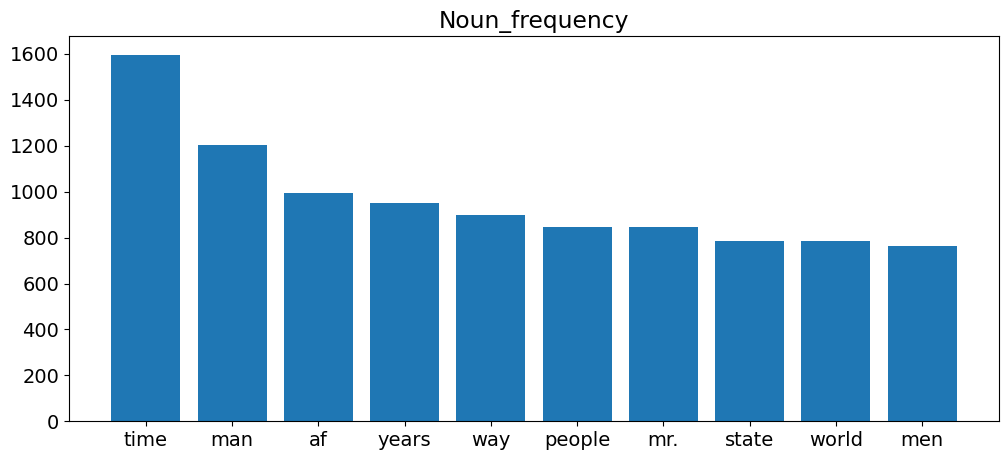

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(words_noun_num.index[:10], words_noun_num.values[:10])
plt.title("Noun_frequency")
plt.show()

In [ ]:
most_popular_noun = words_noun_num.index[0]
print(most_popular_noun)

time


Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [ ]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1.

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents, dtype='object')

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1,
                                           shuffle=True, random_state=22)

In [ ]:
train_sents[0]

[('for', 'ADP'),
 ('it', 'PRON'),
 ('seems', 'VERB'),
 ('that', 'ADP'),
 ('barco', 'NOUN'),
 (',', '.'),
 ('fancying', 'VERB'),
 ('himself', 'PRON'),
 ('a', 'DET'),
 ("ladies'", 'NOUN'),
 ('man', 'NOUN'),
 ('(', '.'),
 ('and', 'CONJ'),
 ('why', 'ADV'),
 ('not', 'ADV'),
 (',', '.'),
 ('after', 'ADP'),
 ('seven', 'NUM'),
 ('marriages', 'NOUN'),
 ('?', '.'),
 ('?', '.')]

In [ ]:
len(train_sents)

947

In [ ]:
len(test_sents)

106

In [ ]:
test_sents[0]

[('they', 'PRON'),
 ('were', 'VERB'),
 ('clumsy', 'ADJ'),
 (',', '.'),
 ('but', 'CONJ'),
 ('they', 'PRON'),
 ('were', 'VERB'),
 ('beginning', 'VERB'),
 ('to', 'PRT'),
 ('catch', 'VERB'),
 ('on', 'PRT'),
 ('.', '.')]

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [ ]:
class HiddenMarkovModel:
    def __init__(self):
        pass

    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train)
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                for (word, tag) in sent]


        tag_num = pd.Series(nltk.FreqDist(tags)).sort_index()
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)

        self.tags = tag_num.index
        self.words = word_num.index

        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)

        # Вычисляем матрицу A и B по частотам слов и тегов

        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег


        # переходим к вероятностям

        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)

        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)

        self.A = A
        self.B = B

        return self


    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test) # Враньё - тега нет!
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})

        for i_sent in range(len(test_tokens_list)):

            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения

            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax

            for t in range(len_sent):

                # если мы не встречали такое слово в обучении, то вместо него будет
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = most_popular_noun #noun_word[idx_of_freq]  # '''your code'''

                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):

                    s = self.tags[i_s]

                    # формула (1)
                    q[t + 1][i_s] = np.max(q[t, :] *
                        self.A.loc[:, s] *
                        self.B.loc[current_sent[t], s])

                    # argmax формула(1)

                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t, :] * self.A.loc[:, s] *
                        self.B.loc[current_sent[t], s]).reset_index()[s].idxmax() # индекс

            back_point = back_point.astype('int')

            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]

            predict_tags[i_sent] = np.array(back_tag)

        return predict_tags

Обучите скрытую марковскую модель:

In [ ]:
my_model = HiddenMarkovModel()

In [ ]:
my_model.fit(train_sents)

In [ ]:
my_model.A

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.239666,0.035300,0.094287,0.063168,0.095680,0.104505,0.100790,0.006503,0.102647,0.038086,0.116117,0.003251
ADJ,0.161943,0.055061,0.092308,0.013765,0.034008,0.008097,0.580567,0.002429,0.010526,0.025911,0.012955,0.002429
ADP,0.018683,0.060252,0.023821,0.017282,0.000934,0.455395,0.241009,0.015413,0.110696,0.019617,0.036432,0.000467
ADV,0.184866,0.159004,0.102490,0.090996,0.014368,0.065134,0.029693,0.007663,0.079502,0.028736,0.236590,0.000958
CONJ,0.057632,0.098131,0.070093,0.102804,0.001558,0.138629,0.163551,0.014019,0.102804,0.021807,0.224299,0.004673
DET,0.016780,0.222222,0.005896,0.019501,0.000000,0.004535,0.647619,0.006349,0.016780,0.001361,0.056689,0.002268
NOUN,0.334090,0.010598,0.214232,0.035074,0.062831,0.016654,0.130204,0.001262,0.028514,0.020187,0.145597,0.000757
NUM,0.103704,0.118519,0.148148,0.000000,0.029630,0.007407,0.518519,0.037037,0.000000,0.007407,0.029630,0.000000
PRON,0.110204,0.004082,0.059592,0.055510,0.008980,0.024490,0.004082,0.004898,0.006531,0.020408,0.700408,0.000816
PRT,0.128548,0.016694,0.098497,0.056761,0.011686,0.085142,0.018364,0.003339,0.008347,0.013356,0.559265,0.000000


In [ ]:
my_model.B

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
",",0.386826,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
the,0.000000,0.0,0.0,0.0,0.00000,0.415873,0.000000,0.0,0.0,0.0,0.000000,0.0
.,0.255408,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
a,0.000000,0.0,0.0,0.0,0.00000,0.217234,0.000000,0.0,0.0,0.0,0.000000,0.0
and,0.000000,0.0,0.0,0.0,0.73676,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
imploring,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000315,0.0
blessed,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000315,0.0
forgive,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000315,0.0
desecration,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000252,0.0,0.0,0.0,0.000000,0.0


In [ ]:
my_model.A.loc['.'].sum() # Проверка, что сумма равна 1

1.0

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [ ]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
lower_sents = [list(map(lambda x: x.lower(), sent)) for sent in sents]
lower_sents

[['he', 'can', 'stay'],
 ['a', 'cat', 'and', 'a', 'dog'],
 ['i', 'have', 'a', 'television'],
 ['my', 'favourite', 'character']]

In [ ]:
my_model.predict(sents)

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

### Вопрос 3:
* Какой тег вы получили для слова `can`?

In [ ]:
my_model.predict(sents)[0][1]

'VERB'

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

In [ ]:
my_model.predict(sents)[3][1]

'NOUN'

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы.

In [ ]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
       # tags = [tup[1] for tup in sent] #'''your code'''
       # words = [tup[0] for tup in sent] #'''your code'''
        tags = [tag for (word, tag) in sent] # '''your code'''
        words = [word for (word, tag) in sent]

        #prediction = model.predict([words])     #'''your code'''
        preds = model.predict([words])[0]
        print('tags:', tags)
        print('words:', words)
        print('prediction:', preds)


        #true_pred += sum([prediction[0][i] == tags[i] for i in range(len(tags))])  #'''your code'''
        true_pred += sum([tag == pred for tag, pred in zip(tags, preds)])
        num_pred += len(tags) #'''your code'''
    print("Accuracy:", true_pred / num_pred * 100, '%')

In [ ]:
accuracy_score(my_model, test_sents)

tags: ['PRON', 'VERB', 'ADJ', '.', 'CONJ', 'PRON', 'VERB', 'VERB', 'PRT', 'VERB', 'PRT', '.']
words: ['they', 'were', 'time', ',', 'but', 'they', 'were', 'beginning', 'to', 'time', 'on', '.']
prediction: ['PRON' 'VERB' 'NOUN' '.' 'CONJ' 'PRON' 'VERB' 'NOUN' 'ADP' 'NOUN' 'ADP'
 '.']
tags: ['CONJ', 'PRON', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', '.']
words: ['and', 'they', 'had', 'told', 'their', 'mother', 'about', 'the', 'time', '.']
prediction: ['CONJ' 'PRON' 'VERB' 'VERB' 'DET' 'NOUN' 'ADP' 'DET' 'NOUN' '.']
tags: ['PRON', 'VERB', 'ADP', 'DET', 'NOUN', 'VERB', 'ADV', 'VERB', 'DET', 'NOUN', '.', 'CONJ', 'VERB', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'NOUN', '.']
words: ['i', 'discovered', 'that', 'the', 'girls', 'had', 'time', 'time', 'the', 'kitchen', ',', 'and', 'were', 'playing', 'quietly', 'in', 'the', 'living', 'room', '.']
prediction: ['PRON' 'VERB' 'ADP' 'DET' 'NOUN' 'VERB' 'NOUN' 'NOUN' 'DET' 'NOUN' '.'
 'CONJ' 'VERB' 'VERB' 'ADV' 'ADP' 'DET' 'VERB' 'NOUN' '.']
tags:

### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

In [ ]:
88.6

88.6

## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [ ]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger('NOUN')

In [ ]:
true_pred = 0
num_pred = 0
for sent in test_sents:
  tags = [tup[1] for tup in sent]
  words = ([tup[0] for tup in sent])
  popular_tag = [tup[1] for tup in default_tagger.tag(words)]
  true_pred += sum([popular_tag[i] == tags[i] for i in range(len(tags))])  #'''your code'''
  num_pred += len(tags) #'''your code'''
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 20.146856356126662 %


In [ ]:
20.1

20.1

## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [ ]:
from nltk.tag.mapping import map_tag

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
# nltk.pos_tag(..., tagset='universal')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.tag import pos_tag
pos_tagger = pos_tag

In [ ]:
from nltk.tag import pos_tag
pos_tagger = pos_tag
true_pred = 0
num_pred = 0
for sent in test_sents:
  tags = [tup[1] for tup in sent]
  words = ([tup[0] for tup in sent])
  prediction = [out[1] for out in pos_tagger(words, tagset='universal')]
  true_pred += sum([prediction[i] == tags[i] for i in range(len(tags))])  #'''your code'''
  num_pred += len(tags) #'''your code'''
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 90.3625516291877 %


In [ ]:
!pip install -q rnnmorph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 67.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 69.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [ ]:
true_pred = 0
num_pred = 0
for sent in test_sents:
  tags = [tup[1] for tup in sent]
  words = ([tup[0] for tup in sent])
  prediction = [out.pos for out in predictor.predict(words)]
  true_pred += sum([prediction[i] == tags[i] for i in range(len(tags))])  #'''your code'''
  num_pred += len(tags) #'''your code'''
print("Accuracy:", true_pred / num_pred * 100, '%')

1/1 [==============================] - 0s 36ms/step
Accuracy: 64.02019274896742 %


### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

In [ ]:
'''
pos_tag - 90.3625516291877%
RNNMorphPredictor - 64.02019274896742%
'''

'\npos_tag - 90.3625516291877%\nRNNMorphPredictor - 64.02019274896742%\n'

## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [ ]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents] # мб my_brown_tagged_sents использовать вместо brown_tagged_sents?
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [ ]:
!python --version

Python 3.10.11


In [ ]:
#!pip install -U torch==1.8.0 torchtext==0.9.0

# Reload environment
#exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.8.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.8.0


In [ ]:
import torchtext
torchtext.__version__

'0.6.0'

In [ ]:
!pip install -U torchtext==0.6.0

exit()

In [ ]:
from torchtext.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

In [ ]:
WORD

Вот один наш пример:

In [ ]:
print(vars(examples[0]))

{'words': ['it', 'was', 'among', 'these', 'that', 'hinkle', 'identified', 'a', 'photograph', 'of', 'barco', '!', '!'], 'tags': ['PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.']}


Теперь формируем наш датасет

In [ ]:
# кладем примеры в наш датасет
dataset = torchtext.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 842
Number of validation examples: 106
Number of testing examples: 105


In [ ]:
for word in train_data.tags:
  print(word)

In [ ]:
train_data

Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [ ]:
WORD.build_vocab(train_data.words, min_freq=2)
TAG.build_vocab(train_data.tags)

print(f"Unique tokens in source (en) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (en) vocabulary: 1303
Unique tokens in target (en) vocabulary: 13
['<unk>', 'took', 'doubt', 'job', 'broken', "ladies'", 'somersaults']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'PRON', 'ADJ', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


In [ ]:
print(vars(train_data.examples[9]))

{'words': ['now', 'the', 'czarship', 'had', 'not', 'affected', 'my', 'own', 'sense', 'of', 'social', 'values', ',', 'but', 'mother', 'had', 'attained', 'a', 'reflected', 'glory', 'through', 'it', ',', 'which', 'had', 'opened', 'the', 'doors', 'of', 'los', 'angeles-pasadena', 'society', 'to', 'her', '.'], 'tags': ['ADV', 'DET', 'NOUN', 'VERB', 'ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'NOUN', 'VERB', 'VERB', 'DET', 'VERB', 'NOUN', 'ADP', 'PRON', '.', 'DET', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'PRON', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

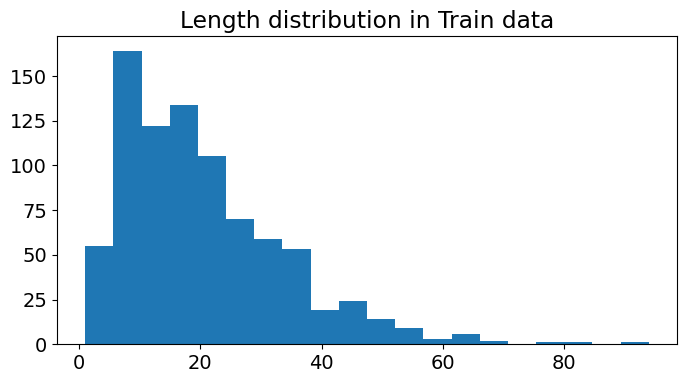

In [ ]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [ ]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[27, 4, 4]

In [ ]:
for batch in train_iterator:
  print('batch:', batch)
  print('batch words:', batch.words)
  print('batch tags:', batch.tags)

batch: 
[torchtext.data.batch.Batch of size 32]
	[.words]:[torch.LongTensor of size 50x32]
	[.tags]:[torch.LongTensor of size 50x32]
batch words: tensor([[   0,   14,    0,  ...,   30,   30,  130],
        [   9,  136,    5,  ...,   91, 1065,    7],
        [   3,  199, 1119,  ...,   12,    2,   86],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
batch tags: tensor([[1, 6, 8,  ..., 4, 4, 7],
        [5, 2, 9,  ..., 1, 1, 5],
        [4, 2, 2,  ..., 2, 3, 4],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
batch: 
[torchtext.data.batch.Batch of size 32]
	[.words]:[torch.LongTensor of size 81x32]
	[.tags]:[torch.LongTensor of size 81x32]
batch words: tensor([[ 14, 128, 176,  ...,  78,  26,   3],
        [118,  19,   2,  ...,   2,   3,   0],
        [  0, 664, 246,  ...,  19, 192,   7],
        ...,
 

### Модель и её обучение

Инициализируем нашу модель

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False):
        super().__init__()


        self.embeddings = nn.Embedding(input_dim, emb_dim, padding_idx=1) #'''your code''' HOW ABOUT padding_idx ???
        self.dropout = nn.Dropout(p=dropout) #'''your code'''

       # self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hid_dim,
       #                   bidirectional=bidirectional) #'''your code'''
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim,
                          bidirectional=bidirectional) #'''your code'''
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):

        #sent = [sent len, batch size]

        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent)) #'''your code'''

        output, _ = self.rnn(embedded) #'''your code'''
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output) #'''your code'''

        return prediction

# параметры модели
INPUT_DIM = len(WORD.vocab) #'''your code'''
OUTPUT_DIM = len(TAG.vocab) #'''your code'''
EMB_DIM = 300 #'''your code'''
HID_DIM = 300 #'''your code'''
DROPOUT = 0.1 #'''your code'''
BIDIRECTIONAL = True #'''your code'''

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM,
                   OUTPUT_DIM ,DROPOUT, BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(1303, 300, padding_idx=1)
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): LSTM(300, 300, bidirectional=True)
  (tag): Linear(in_features=600, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) #'''your code'''

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,843,513 trainable parameters


Погнали обучать

In [ ]:
TAG.vocab.stoi['<pad>']

0

In [ ]:
WORD.vocab.stoi['<pad>']

1

In [ ]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

        '''your code'''
        optimizer.zero_grad()

        input = batch.words.to(device)
        tags = batch.tags.to(device)
        output = model(input)

        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]

        output = output.view(-1, OUTPUT_DIM) #'''your code'''
        tags = tags.view(-1)

        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]

        loss = criterion(output, tags)

        loss.backward()

        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')

            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            input = batch.words.to(device)
            tags = batch.tags.to(device)

            output = model(input)

            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            output = output.view(-1, OUTPUT_DIM)
            tags = tags.view(-1)

            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]

            loss = criterion(output, tags)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

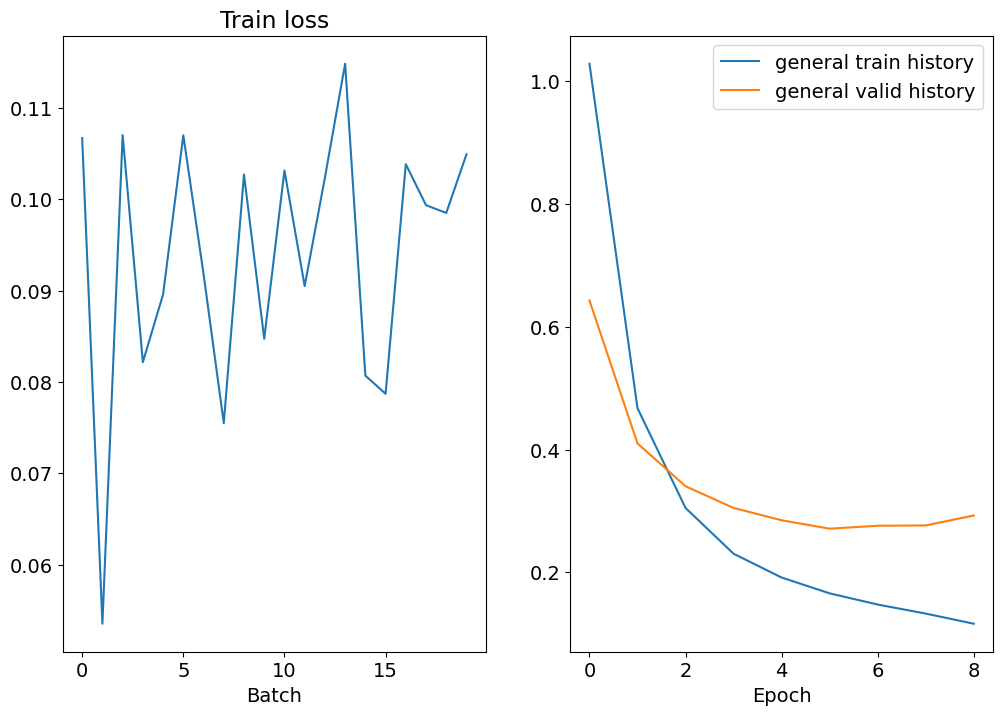

Epoch: 10 | Time: 0m 12s
	Train Loss: 0.099 | Train PPL:   1.104
	 Val. Loss: 0.295 |  Val. PPL:   1.343


In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 10 #'''your code'''
CLIP = 10 #'''your code'''

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion,
                       CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [ ]:
def accuracy_model(model, iterator):
    model.eval()

    true_pred = 0
    num_pred = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):

            input = batch.words.to(device)
            tags = batch.tags.to(device)
            output = model(input)

            #output = [sent len, batch size, output dim]
            #output = output.view(-1, OUTPUT_DIM)
            output = torch.argmax(output, dim=2)
          #  print('output shape:', output.shape)
          #  print('tags shape:', tags.shape)
            #output = [sent len, batch size]

            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()
           # print('predict_tags:', predict_tags)
           # print('true_tags:', true_tags)

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()

    return round(true_pred / num_pred * 100, 3)

In [ ]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 89.564 %


Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

In [ ]:
len(brown_tagged_sents)

57340

In [ ]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents] # мб my_brown_tagged_sents использовать вместо brown_tagged_sents?
print(pos_data[0])

[('The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'), ('DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.')]


In [ ]:
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

In [ ]:
print(vars(examples[0]))

{'words': ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], 'tags': ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']}


In [ ]:
# кладем примеры в наш датасет
dataset = torchtext.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


In [ ]:
WORD.build_vocab(train_data, min_freq=3)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (en) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (en) vocabulary: 18125
Unique tokens in target (en) vocabulary: 13
['<unk>', 'always', 'study', 'instead', 'somewhat', 'gives', 'enemy', 'membership', 'tomorrow', 'yards', 'risk', 'contrary', 'burden', 'simultaneously', 'iron', 'tested', 'challenge', 'bird', 'questionnaire', 'cure', 'prayer', 'terror', 'appreciation', 'anglo-saxon', 'trucks', 'shadows', 'legislators', 'closet', 'shu', 'habitat', 'writings', 'idle', 'yankee', 'illustrations', 'uniforms', 'employ', 'purdew', 'barbara', 'hillside', 'restrain', 'blew', 'gland', 'phonologic', 'trades', 'brazil', 'escort', 'mahogany', 'rusk', 'vientiane', "bull's-eyes", 'downstairs', 'ills', 'oscar', 'scholastic', 'waged', 'blackened', 'della', 'garrison', 'latch', 'peacefully', 'scratched', 'throws', '75%', 'bleachers', 'consummated', 'eagle', 'geographic', 'irritating', 'micrometeorites', 'plaintiff', 'romantics', 'squared', 'uncompromising', '125', 'altitude', 'billie', 'chilling', 'cunningly', 'droplets', 'ferrell

In [ ]:
print(vars(train_data.examples[9]))

{'words': ['she', 'asked', 'bobbie', '.'], 'tags': ['PRON', 'VERB', 'NOUN', '.']}


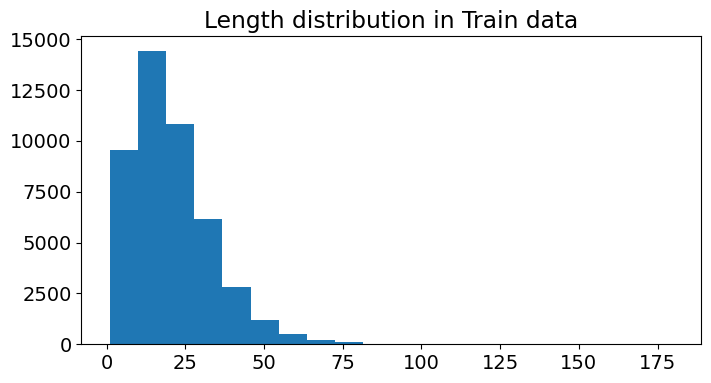

In [ ]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[359, 45, 45]

In [ ]:
INPUT_DIM = len(WORD.vocab) #'''your code'''
OUTPUT_DIM = len(TAG.vocab) #'''your code'''
EMB_DIM = 300 #'''your code'''
HID_DIM = 100 #'''your code'''
DROPOUT = 0.1 #'''your code'''
BIDIRECTIONAL = True #'''your code'''

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM,
                   OUTPUT_DIM ,DROPOUT, BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(18125, 300, padding_idx=1)
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): LSTM(300, 100, bidirectional=True)
  (tag): Linear(in_features=200, out_features=13, bias=True)
)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,761,713 trainable parameters


In [ ]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


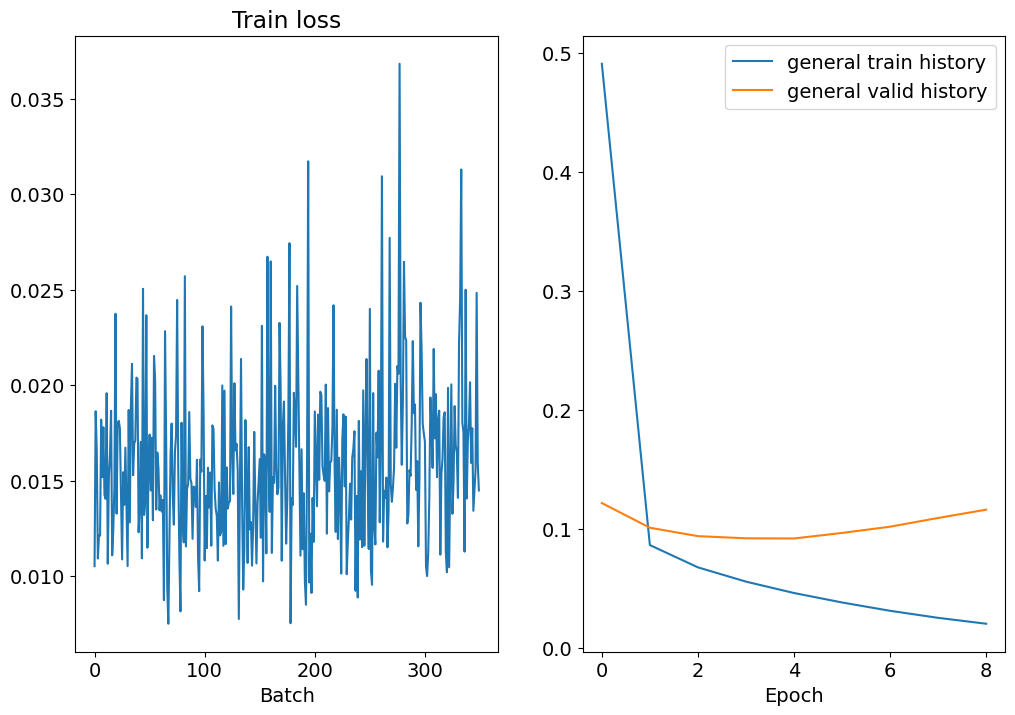

Epoch: 10 | Time: 4m 2s
	Train Loss: 0.016 | Train PPL:   1.016
	 Val. Loss: 0.126 |  Val. PPL:   1.135


In [ ]:
from tqdm.auto import trange
train_history = []
valid_history = []

N_EPOCHS = 10 #'''your code'''
CLIP = 2 #'''your code'''

best_valid_loss = float('inf')

for epoch in trange(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion,
                       CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 96.915 %


Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %`

In [ ]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_iterator) >= 93

Пример решение нашей задачи:

In [ ]:
def print_tags(model, data):
    model.eval()

    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)

        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [ ]:
print_tags(model, pos_data[-1])

From           NOUN
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

In [ ]:
'''
при обучение на категории humor LstmTagger показала почти такой же результата,
однако чуть лучше (89,5% против 88,6%).
При обучении на всём корпусе LSTMTagger показал результат 96%,
что значительно превосходит предыдущий
'''

'\nпри обучение на категории humor LstmTagger показала почти такой же результата, \nоднако чуть лучше (89,5% против 88,6%). \nПри обучении на всём корпусе LSTMTagger показал результат 96%, \nчто значительно превосходит предыдущий\n'